In [1]:
# Invoke a command enabling plotting in the notebook
%matplotlib inline

In [2]:
# Import the libraries and specific package features which are going to be used in the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nose.tools import *

# Import random seed for results reproducibility
np.random.seed(24680)

# Import sklearn features for modelling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from scipy.stats.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Softuni - Machine Learning - Exam Project - Velko Kamenov

### email - velko.kamenov@abv.bg

## Predicting Goal/Goal match outcome in the English Premier League using data between 2000-2017 and comparing different machine learning classification models

### 1. Abstract - Problem definition, scope of the analysis and data used

Forecasting football match outcomes has proven to be a difficult task both because of data availability limitations as well as a  lack of easily trackable structure in the scarse quality data that can be found freely available on the matter. 

The aim of this project is to present an approach for forecasting goal/goal match outcome for the English Premier League football games using data from the last 18 seasons of the competition as well as a handful of machine learning models such as Logistic Regression with and without regularization and combined with PCA, Random Forest and Linear and Gaussian Support Vector Machines. 

__Problem definition__: Binary Classification problem. Goal/Goal - Yes - if both teams in the match score at least one goal each during the course of a given game. Goal/Goal - No - if at least one of the teams in the match doesn't score a goal. 

__Data used__: Freely available statistical data about each game from the last 18 football seasons downloaded in excel csv format from [the following website](http://www.football-data.co.uk/englandm.php). The data is manually downloaded in the csv format in which it is found available and later preprocessed in R so that it is structured in a way enabling machine learning modelling. The statistical information in the files consists of features such as average goals scored by the two sides in a game for the season up until the start of the game, average shots on target per game for the season, average corner kicks per game for the season, bookmaker odds and others. The data was preprocessed so as to produce different predictive features with aggregated information for each team's average performance during the season before the start of a given match. The full set of characteristics derived in this way is available in the text file `Goal Goal Data Variables codebook.txt` in the `data` folder of the project. There can be found detailed explanation of each characteristic in the initial dataset. 

__Intrinsic error in the data__: Given the fact that the average betting odds for Goal/Goal yes/no match outcome is around 1.75 we can calculate that in order to beat the market i.e. to be able to forecast better than the combined opinion of the football betting market, one has to obtain a model with at least 60% accuracy for marginal profits. Thus we can assume that the given the fact that the market also posses this freely available information and also uses it for analysis, the intrinsic error of the data for the case presented is around 40% and the target result of this analysis is to get a model with 60% forecasting accuracy.

__Results from modeling__: After training and testing the forecasting performance of 6 competing models on test data I can conclude that the data collected can modelled so as to forecast better than random, but is not enough to reach the 60% accuracy threshold. More relevant data is needed in order to get closer to this benchmark. Since all models tested give similar results, it is best to choose the simplest one with the best performance - Logistic Regression with regularization. The result of this model is 54% accuracy on the test data. 


### 2. Read and examine data stats

As a first step of the analysis we read the data and look at its shape and values - 5100 observations with 15 predictor features and one target variable

In [3]:
# Read data and get some descriptive statistics
football_data = pd.read_csv("data/GoalGoalData.csv",sep=",")

# Check number of observations and features in the dataset
print(football_data.shape)

# Look at summary statistics of the data
descriptiveStats = pd.DataFrame(football_data.describe())

descriptiveStats

(5100, 16)


,GoalGoal,B365H,B365D,B365A,AverageHTSShifted,AverageATSShifted,AverageHomeTeamSavesShifted,AverageAwayTeamSavesShifted,AverageHCShifted,AverageACShifted,AverageHGShifted,AverageAGShifted,PercentageMGSHShifted,PercentageMGSAShifted,PercentageMGCHShifted,PercentageMGCAShifted
count,5100.000000,5094.000000,5094.000000,5094.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,0.500784,2.660684,3.842344,4.741698,6.515009,5.071738,3.886536,5.024792,6.243825,4.898824,1.530990,1.164611,0.777133,0.669895,0.666175,0.781089
std,0.500048,1.740452,1.006842,3.748453,2.198762,1.643656,1.452777,1.829051,1.424478,1.140127,0.581516,0.497391,0.157920,0.185444,0.179451,0.161976
min,0.000000,1.080000,2.500000,1.160000,1.400000,1.000000,0.750000,0.750000,1.750000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.660000,3.250000,2.500000,4.941176,3.900000,2.777778,3.562500,5.250000,4.125000,1.142857,0.800000,0.666667,0.555556,0.562500,0.687500
50%,1.000000,2.100000,3.500000,3.500000,6.444444,4.882353,3.666667,5.000000,6.125000,4.812500,1.428571,1.100000,0.777778,0.666667,0.666667,0.800000
75%,1.000000,2.800000,4.000000,5.500000,7.800000,6.000000,4.900000,6.338235,7.055556,5.600000,1.800000,1.444444,0.875000,0.800000,0.785714,0.888889
max,1.000000,17.000000,13.000000,34.000000,19.000000,14.333333,11.600000,11.833333,18.000000,12.666667,5.666667,4.000000,1.500000,1.333333,1.333333,1.333333


#### Check some averages

In [4]:
# Show the average values for the target and predictor variables
descriptiveStats.iloc[1]

GoalGoal                       0.500784
B365H                          2.660684
B365D                          3.842344
B365A                          4.741698
AverageHTSShifted              6.515009
AverageATSShifted              5.071738
AverageHomeTeamSavesShifted    3.886536
AverageAwayTeamSavesShifted    5.024792
AverageHCShifted               6.243825
AverageACShifted               4.898824
AverageHGShifted               1.530990
AverageAGShifted               1.164611
PercentageMGSHShifted          0.777133
PercentageMGSAShifted          0.669895
PercentageMGCHShifted          0.666175
PercentageMGCAShifted          0.781089
Name: mean, dtype: float64

By looking at the mean values for the target and predictor variables we find some intresting facts for the matches in the English Premier League during the last 18 seasons. 

Generally as we can expect home teams more often dominate in the matches which is proven by the fact that on average they manage to produce 1.5 more shots on target per match, score 0.37 more goals per match and score at least one goal in 10% more of the matches compared to away teams. 

This means that whether a match ends with both teams scoring a goal probably depends a lot on the ability of the away team to score a goal, since home teams score goals in the game more often than not. 

### Remove rows with missing values
As we see from the table above there are three feature columns with 6 missing values - B365H, B365D and B365A. As the number of missing values is low and many algorithms work better with no missing values in the features we shall remove the rows with missing information from them. 

In [5]:
# Remove rows with missing values
football_data = football_data.dropna(thresh=15) # drop rows with one or more na values

# Print the shape of the data - the 6 rows with NA values are dropped
print(football_data.shape)
# Check again the statistics for the features in the data
football_data.describe()

(5094, 16)


,GoalGoal,B365H,B365D,B365A,AverageHTSShifted,AverageATSShifted,AverageHomeTeamSavesShifted,AverageAwayTeamSavesShifted,AverageHCShifted,AverageACShifted,AverageHGShifted,AverageAGShifted,PercentageMGSHShifted,PercentageMGSAShifted,PercentageMGCHShifted,PercentageMGCAShifted
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,0.500589,2.660684,3.842344,4.741698,6.513458,5.072918,3.887731,5.026162,6.240222,4.898323,1.530240,1.164543,0.776923,0.669986,0.666150,0.781011
std,0.500049,1.740452,1.006842,3.748453,2.197006,1.644121,1.452862,1.829484,1.414980,1.137705,0.581019,0.497165,0.157526,0.185494,0.179383,0.162010
min,0.000000,1.080000,2.500000,1.160000,1.400000,1.000000,0.750000,0.750000,1.750000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.660000,3.250000,2.500000,4.941176,3.900000,2.777778,3.571429,5.250000,4.125000,1.142857,0.800000,0.666667,0.555556,0.562500,0.687500
50%,1.000000,2.100000,3.500000,3.500000,6.444444,4.882353,3.666667,5.000000,6.125000,4.812500,1.428571,1.100000,0.777778,0.666667,0.666667,0.800000
75%,1.000000,2.800000,4.000000,5.500000,7.800000,6.000000,4.900000,6.352941,7.000000,5.600000,1.800000,1.444444,0.875000,0.800000,0.785714,0.888889
max,1.000000,17.000000,13.000000,34.000000,19.000000,14.333333,11.600000,11.833333,13.666667,12.666667,5.666667,4.000000,1.333333,1.333333,1.333333,1.333333


### Check for correlations and remove correlated variables
After removing the missing values and given the fact that all predictor variables are numeric as next step we can safely check for correlations among the predictors. 



Correlation between B365D and B365A:
(0.8357088594974189, 0.0)
Correlation between PercentageMGSHShifted and AverageHGShifted:
(0.7307233001540712, 0.0)
Correlation between PercentageMGSAShifted and AverageAGShifted:
(0.8004313444256618, 0.0)


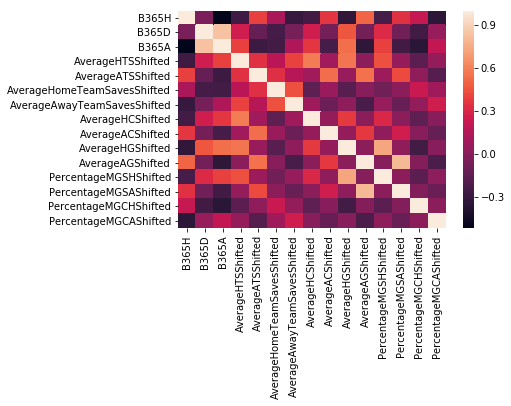

In [6]:
# Check correlations in the data
football_data_predictors = football_data.drop("GoalGoal",axis=1)
corr = football_data_predictors.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.rcParams['figure.figsize'] = (10,7)
# Print the highest correlations
print("Correlation between B365D and B365A:")
print(pearsonr(football_data["B365D"],football_data["B365A"]))
print("Correlation between PercentageMGSHShifted and AverageHGShifted:")
print(pearsonr(football_data["PercentageMGSHShifted"],football_data["AverageHGShifted"]))
print("Correlation between PercentageMGSAShifted and AverageAGShifted:")
print(pearsonr(football_data["PercentageMGSAShifted"],football_data["AverageAGShifted"]))


By the plot generated above we see that most of the predictors are uncorrelated but still there are some substantial correlations among some of them. We shall address this issue as these predictors esentially bring the same information about the data. 

There is high correlation between draw and away win betting odds (B365D and B365A variables) - 0.84. We see from the table with descriptive statistics that home teams are more common to score a goal in the game(they score on average in 78% of the cases vs. 67% for the away teams with average goals equal to 1.53 vs 1.16 for the away teams). This means that on average high away team win odds are not going to be very common and probably this information would be very usefull for the purposes of future modeling. Moreover the away team win odds (B365A) have higher variation than B365D odds. That's is why of these two variables we are going to keep the B365A variable and drop B365D. 

There is also high correlation between two more pairs of variables - PercentageMGSHShifted and AverageHGShifted (0.73) as well as PercentageMGSAShifted and AverageAGShifted (0.8). 

However, here I am not going to remove any of these variables, but try a little different approach - based on domain knowledge about the data I am going to feature engineer two features out of the last 4 columns and check the correlations again. I am going to define a new variable PercentageHomeToScore which is going to represent the sum of PercentageMGSHShifted and PercentageMGCAShifted as well as a new variable PercentageAwayToScore - the sum of PercentageMGSAShifted and PercentageMGCHShifted. 

### Perform feature engineering

In [7]:
# Compile 4 columns in two based on domain knowledge logic - match between strong attack and weak deffence
football_data['PercentageHomeToScore'] = football_data['PercentageMGSHShifted'] + football_data['PercentageMGCAShifted']

football_data['PercentageAwayToScore'] = football_data['PercentageMGSAShifted'] + football_data['PercentageMGCHShifted']

football_data = football_data.drop(["PercentageMGSHShifted","PercentageMGCAShifted",
                                         "PercentageMGSAShifted","PercentageMGCHShifted","B365D"], axis = 1)

football_data.head()


,GoalGoal,B365H,B365A,AverageHTSShifted,AverageATSShifted,AverageHomeTeamSavesShifted,AverageAwayTeamSavesShifted,AverageHCShifted,AverageACShifted,AverageHGShifted,AverageAGShifted,PercentageHomeToScore,PercentageAwayToScore
0,0,1.83,5.25,3.666667,1.75,1.666667,3.25,5.333333,5.50,1.666667,0.25,1.75,0.583333
1,1,1.36,10.00,4.750000,4.25,2.250000,1.75,5.750000,4.75,1.000000,2.00,1.00,1.500000
2,1,11.00,1.36,3.250000,5.25,2.750000,3.25,6.000000,5.75,0.500000,1.75,0.75,1.250000
3,0,1.11,26.00,8.250000,3.50,1.000000,5.00,7.000000,4.25,4.500000,1.50,1.75,1.500000
4,0,2.00,4.20,4.750000,1.75,2.750000,5.00,5.000000,5.50,1.500000,0.00,1.75,0.750000


### Check correlations again 
Now there are no more substansive correlations among variables and we can continue with modeling. 

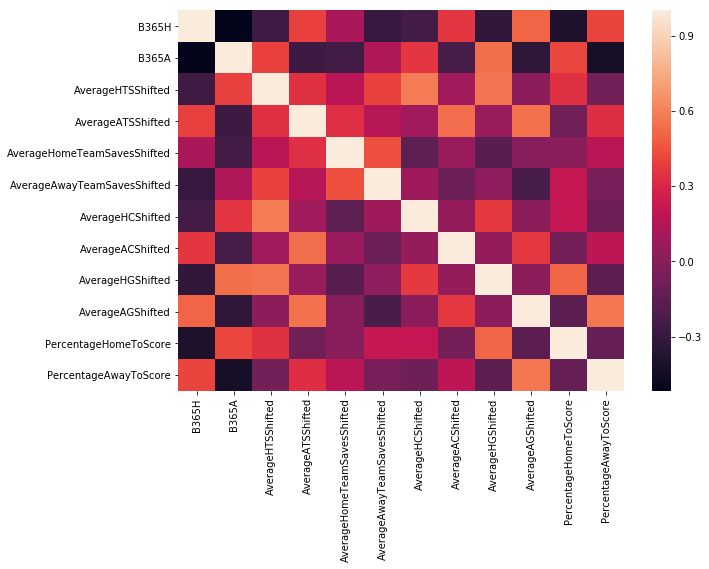

In [8]:
# Check correlations again
football_data_predictors = football_data.drop("GoalGoal",axis=1)
corr = football_data_predictors.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.rcParams['figure.figsize'] = (10,7)

### Divide attributes from labels

In [9]:
# Divide attributes from labels
football_attributes = football_data.drop("GoalGoal", axis = 1)
football_labels = football_data['GoalGoal']

# Show dimensions and first few observations of the data
print(football_attributes.shape)
print(football_labels.shape)
football_data.head()

(5094, 12)
(5094,)


,GoalGoal,B365H,B365A,AverageHTSShifted,AverageATSShifted,AverageHomeTeamSavesShifted,AverageAwayTeamSavesShifted,AverageHCShifted,AverageACShifted,AverageHGShifted,AverageAGShifted,PercentageHomeToScore,PercentageAwayToScore
0,0,1.83,5.25,3.666667,1.75,1.666667,3.25,5.333333,5.50,1.666667,0.25,1.75,0.583333
1,1,1.36,10.00,4.750000,4.25,2.250000,1.75,5.750000,4.75,1.000000,2.00,1.00,1.500000
2,1,11.00,1.36,3.250000,5.25,2.750000,3.25,6.000000,5.75,0.500000,1.75,0.75,1.250000
3,0,1.11,26.00,8.250000,3.50,1.000000,5.00,7.000000,4.25,4.500000,1.50,1.75,1.500000
4,0,2.00,4.20,4.750000,1.75,2.750000,5.00,5.000000,5.50,1.500000,0.00,1.75,0.750000


### Examine target variable distribution

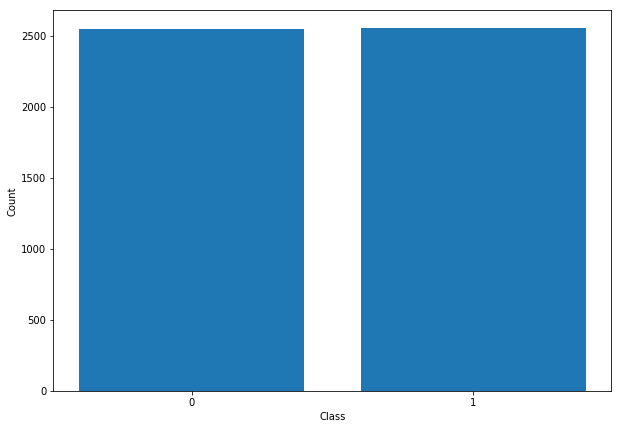

Positive cases: 50.06% of all


In [10]:
# Get the distribution of the target variable which is going to be predicted
# There's nothing to do here, just execute the cell and view the plot and print results.
# Cells like these are here only for your convenience and to help you understand the task better
plt.bar([0, 1], [len(football_labels[football_labels == 0]), len(football_labels[football_labels == 1])])
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Positive cases: {:.2f}% of all".format(football_labels.sum() / len(football_labels) * 100))

# No need for stratification and accuracy is a good measure for models performance

We see from the graph above that the tow classes of the target variable are perfectly distributed - 50% cases in each class. This means that the accuracy measure is going to work fine for model optimization and selection at later stages of the analysis. Also there will be no need to stratify the train, validation and test sets. 

### Rescale the data
As we saw from the table with descriptive statistics at the beginning the predictor variables are at different scales so on this step I am going to rescale them to have mean = 0 and variance = 1 in order not to bias the modeling results. 

In [11]:
# Rescale the data so that each variable has mean = 0 and variance = 1
football_attributes_rescaled = pd.DataFrame(preprocessing.scale(football_attributes))
# Set column names in order not to lose variable names
football_attributes_rescaled.columns = list(football_attributes)

# Overwrite bank attributes with rescaled variables
football_attributes = football_attributes_rescaled
football_attributes.head()


,B365H,B365A,AverageHTSShifted,AverageATSShifted,AverageHomeTeamSavesShifted,AverageAwayTeamSavesShifted,AverageHCShifted,AverageACShifted,AverageHGShifted,AverageAGShifted,PercentageHomeToScore,PercentageAwayToScore
0,-0.477328,0.135616,-1.295887,-2.021289,-1.528901,-0.970949,-0.640983,0.528903,0.234828,-1.839697,0.839919,-2.943624
1,-0.747399,1.402930,-0.802743,-0.500571,-1.127355,-1.790933,-0.346486,-0.130384,-0.912694,1.680606,-2.439885,0.640746
2,4.791936,-0.902247,-1.485557,0.107717,-0.783173,-0.970949,-0.169787,0.748665,-1.773336,1.177706,-3.533152,-0.336810
3,-0.891054,5.671776,0.790490,-0.956786,-1.987811,-0.014302,0.537006,-0.569908,5.111799,0.674805,0.839919,0.640746
4,-0.379642,-0.144527,-0.802743,-2.021289,-0.783173,-0.014302,-0.876581,0.528903,-0.052052,-2.342597,0.839919,-2.291920


### Start modeling using different machine learning algorithms and approaches

## Split the data in training and test set

In [12]:
# Split the data in training and test set
np.random.seed(24680)

# Perform train/test split
football_attributes_train, football_attributes_test, football_labels_train, football_labels_test = train_test_split(football_attributes,football_labels,
                                                                                              train_size = 0.7,
                                                                                             test_size = 0.3)

# Check the shape of the newly produced train and test data frames 
print(football_attributes_train.shape)
print(football_attributes_test.shape)
print(football_labels_train.shape)
print(football_labels_test.shape)

(3565, 12)
(1529, 12)
(3565,)
(1529,)


### Logistic Regression - with no regularization

In [13]:
np.random.seed(24680)
# Train base logistic regression model with no regularization
model_log_reg_basic = LogisticRegression(C = 1e6)
model_log_reg_basic.fit(football_attributes_train,football_labels_train)

model_log_reg_basic_accuracy_train = model_log_reg_basic.score(football_attributes_train, football_labels_train)
model_log_reg_basic_accuracy = model_log_reg_basic.score(football_attributes_test, football_labels_test)

# Print accuracy score
print("Logistic Regression with no regularization accuracy on the train set: {:.2f}%.".format(model_log_reg_basic_accuracy_train*100))
print("Logistic Regression with no regularization accuracy on the test set: {:.2f}%.".format(model_log_reg_basic_accuracy*100))

# Calculate f1 score on the test set in order to check another performance metric

# Make predictions on the test set
y_pred_log_reg_basic = model_log_reg_basic.predict(football_attributes_test)

# Use the f1 score metric - taking into account precision and recall
model_log_reg_basic_score_f1 = f1_score(football_labels_test, y_pred_log_reg_basic, average='binary')

print("Logistic Regression with no regularization f1 score on the test set: {:.2f}.".format(model_log_reg_basic_score_f1))


Logistic Regression with no regularization accuracy on the train set: 54.67%.
Logistic Regression with no regularization accuracy on the test set: 53.56%.
Logistic Regression with no regularization f1 score: 0.55.


With the base logistic regression model with no regularization we get performance better than random but still far from the 60% accuracy threshold we are aiming for. 

The performance on the test set is not very far away from the accuracy on the train set meaning that the algorithm generalizes well, but is either weak or the data is not good enough for better predictions. 

### Logistic regression with regularization parameter tuning

In [14]:
np.random.seed(24680)
# Tune logistic regression parameters using a grid search
tuned_params_log_reg = [{"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 "max_iter": [1, 10, 50, 100, 300, 1000],
                 "fit_intercept": [True,False]}]

# Perform grid search with cv = 10 since the whole train set is 3536 10% of it is 354 observation
# for each validation fold which is enough as it comes to number of observations
grid_search_log_reg = GridSearchCV(LogisticRegression(), tuned_params_log_reg, scoring = 'accuracy',cv = 10) 

grid_search_log_reg.fit(football_attributes_train, football_labels_train)

#print(grid_search.best_params_)
grid_search_log_reg.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
# Use the logistic regression model obtained via grid search to calculate accuracy and f1 score on the test set
gridModel_log_reg= grid_search_log_reg.best_estimator_
gridModel_log_reg.fit(football_attributes_train, football_labels_train)

tuned_model_accuracy_train = gridModel_log_reg.score(football_attributes_train, football_labels_train)
print("Logistic Regression with tuned regularization accuracy on train set: {:.2f}%.".format(tuned_model_accuracy_train*100))
tuned_model_accuracy = gridModel_log_reg.score(football_attributes_test, football_labels_test)
print("Logistic Regression with tuned regularization accuracy on the test set: {:.2f}%.".format(tuned_model_accuracy*100))

# Make predictions on the test set
y_pred_grid_model_log_reg = gridModel_log_reg.predict(football_attributes_test)

tuned_score_f1 = f1_score(football_labels_test, y_pred_grid_model_log_reg, average='binary')
print("Logistic Regression with tuned regularization f1 score: {:.2f}.".format(tuned_score_f1))


Logistic Regression with tuned regularization accuracy on train set: 54.64%.
Logistic Regression with tuned regularization accuracy on the test set: 53.76%.
Logistic Regression with tuned regularization f1 score: 0.56.


With the tuned regularized logistic regression we get marginally better results on the test set meaning that the model generalizes a bit better and we have got rid of some minimal overfitting. 

### Random forest with parameter tuning

In [16]:
# Train more models and compare to the base algorithm (logistic regression) results
np.random.seed(24680)

# Tune random forest parameters using a grid search - only the max_depth of the trees parameter as well as the n_estimators
tuned_params_random_forest = [{"max_depth": [10,20,50,75,100,150], 
                 "n_estimators": [10,50,100,200,300,400]}]


grid_search_random_forest = GridSearchCV(RandomForestClassifier(), tuned_params_random_forest, scoring = 'accuracy',cv = 10)
grid_search_random_forest.fit(football_attributes_train, football_labels_train)

forest_classifier = grid_search_random_forest.best_estimator_

print("Random forest; best score:", grid_search_random_forest.best_score_)

Random forest; best score: 0.5329593267882188


In [17]:
forest_classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
# This is the model obtained via the grid search - in order not to be necessary to run the optimization again
np.random.seed(24680)
forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
forest_classifier.fit(football_attributes_train, football_labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
# Check random forest classifier performance on the test set
random_forest_score_accuracy_train = forest_classifier.score(football_attributes_train, football_labels_train)
print("Random Forrest Tuned accuracy on the train set: {:.2f}%.".format(random_forest_score_accuracy_train*100))
random_forest_score_accuracy_test = forest_classifier.score(football_attributes_test, football_labels_test)
print("Random Forrest Tuned accuracy on the test set: {:.2f}%.".format(random_forest_score_accuracy_test*100))

# Calculate f1 score on the test set in order to check another performance metric

# Make predictions on the test set
y_pred_random_forest = forest_classifier.predict(football_attributes_test)

# Use the f1 score metric - taking into account precision and recall
random_forest_score_f1 = f1_score(football_labels_test, y_pred_random_forest, average='binary')
print("Random Forrest Tuned f1 score: {:.2f}.".format(random_forest_score_f1))


Random Forrest Tuned accuracy on the train set: 100.00%.
Random Forrest Tuned accuracy on the test set: 50.75%.
Random Forrest Tuned f1 score: 0.51.


The Random Forrest model has __overfitted the training data__ giving 100% accuracy on the train set but performing very bad on the test set. It seems more powerfull models don't help in this case as learning very specific info about some data points makes the whole model perform worse on unseen data compared to simpler models.

### Linear SVM

In [57]:
# Train linear svm model to compare to the rest models
np.random.seed(24680)

# Tune gaussian SVM parameters using a grid search
tuned_params_linear_svm = [{"C": [0.01,0.1,1,5,10,15,20,30]}]

grid_search_linear_svm = GridSearchCV(SVC(probability=True), tuned_params_linear_svm, scoring = 'accuracy',cv = 10)
grid_search_linear_svm.fit(football_attributes_train, football_labels_train)

linear_svm_classifier = grid_search_linear_svm.best_estimator_

print("Linear SVM; best score:", grid_search_linear_svm.best_score_)

Linear SVM; best score: 0.5309957924263674


In [58]:
linear_svm_classifier

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
# Check linear svm classifier performance on the test set
# These are the results of the grid search procedure
linear_svm_classifier = SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

linear_svm_classifier.fit(football_attributes_train, football_labels_train)

linear_svm_score_accuracy_train = linear_svm_classifier.score(football_attributes_train, football_labels_train)
print("Linear SVM Tuned accuracy on train set: {:.2f}%.".format(linear_svm_score_accuracy_train*100))

linear_svm_score_accuracy = linear_svm_classifier.score(football_attributes_test, football_labels_test)
print("Linear SVM Tuned accuracy on test set: {:.2f}%.".format(linear_svm_score_accuracy*100))

# Calculate f1 score on the test set in order to check another performance metric

# Make predictions on the test set
y_pred_linear_svm = linear_svm_classifier.predict(football_attributes_test)

# Use the f1 score metric - taking into account precision and recall
linear_svm_score_f1 = f1_score(football_labels_test, y_pred_linear_svm, average='binary')
print("Linear SVM Tuned f1 score: {:.2f}.".format(linear_svm_score_f1))

Linear SVM Tuned accuracy on train set: 56.24%.
Linear SVM Tuned accuracy on test set: 54.15%.
Linear SVM Tuned f1 score: 0.57.


The linear SVM model performs a little better than the tuned logistic regression model on the test set. The difference between the accuracy on the train and test set is not very big meaning the model has not overfitted the data.

### Gaussian SVM

In [46]:
# Train gaussian svm model to compare to the rest models
np.random.seed(24680)

# Tune gaussian SVM parameters using a grid search
tuned_params_gaussian_svm = [{"C": [1,5,10,15,20,30,40,50],
                "gamma": [0.001,0.01,0.1,0.2,0.3]}]

grid_search_gaussian_svm = GridSearchCV(SVC(probability=True), tuned_params_gaussian_svm, scoring = 'accuracy',cv = 10)
grid_search_gaussian_svm.fit(football_attributes_train, football_labels_train)

gaussian_svm_classifier = grid_search_gaussian_svm.best_estimator_

print("Gaussian SVM; best score:", grid_search_gaussian_svm.best_score_)

Gaussian SVM; best score: 0.5340813464235624


In [47]:
gaussian_svm_classifier

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
# Check gaussian svm classifier performance on the test set
# These are the results of the grid search procedure
gaussian_svm_classifier = SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

gaussian_svm_classifier.fit(football_attributes_train, football_labels_train)

gaussian_svm_score_accuracy_train = gaussian_svm_classifier.score(football_attributes_train, football_labels_train)
print("Gaussian SVM Tuned accuracy on the train set: {:.2f}%.".format(gaussian_svm_score_accuracy_train*100))

gaussian_svm_score_accuracy = gaussian_svm_classifier.score(football_attributes_test, football_labels_test)
print("Gaussian SVM Tuned accuracy on the test set: {:.2f}%.".format(gaussian_svm_score_accuracy*100))

# Calculate f1 score on the test set in order to check another performance metric

# Make predictions on the test set
y_pred_gaussian_svm = gaussian_svm_classifier.predict(football_attributes_test)

# Use the f1 score metric - taking into account precision and recall
gaussian_svm_score_f1 = f1_score(football_labels_test, y_pred_gaussian_svm, average='binary')
print("Gaussian SVM Tuned f1 score: {:.2f}.".format(gaussian_svm_score_f1))


Gaussian SVM Tuned accuracy on the train set: 55.90%.
Gaussian SVM Tuned accuracy on the test set: 53.63%.
Gaussian SVM Tuned f1 score: 0.57.


The Gaussian SVM model performs slightly worse as it comes to accuracy compared to the regularized logistic regression and slightly better as it comes to f1 score.

This means that there are some parts of the probability distribution of the score in which the Gaussian SVM model performs better but the overall performance as it comes to accuracy is not better. 

As it comes to generalization the gaussian SVM does a good job as well as the logistic regression models and the linear SVM model.

### Perform PCA analysis and model on the principal components

All models tried up to this point give similar results. So in this case we shall choose the simplest one giving the best results - regularized logistic regression. 

It seems this is the limit of the data and more powerful algorithms won't be able to produce better results. 

However, we may try one more option - reduce the dimensionallity of the data a bit with PCA in and see if this feature engineering would yield better results. 



In [26]:
# Perform pca analysis in order to extract only the most valuable information
# Get the principal components explaining ar least 75% of the variance in the data - in this case 5
pca = PCA(n_components=5)
pca.fit(football_attributes)

print("First 5 PCs total variance explained: {:.2f}%.".format(sum(pca.explained_variance_ratio_)*100))

print(pca.explained_variance_ratio_)

comp = pd.DataFrame(pca.transform(football_attributes))

# Set colnames to PC1, PC2, PC3, PC4 and PC5
comp.columns = ['PC1','PC2','PC3','PC4','PC5']

print(comp.shape)
comp.head()


First 5 PCs total variance explained: 78.59%.
[0.29730906 0.20928312 0.13627877 0.07488586 0.06818471]
(5094, 5)


,PC1,PC2,PC3,PC4,PC5
0,-1.947260,-3.096358,-1.180024,1.226592,-2.216704
1,1.158216,-1.419123,-2.082197,0.252200,1.385478
2,4.982393,-1.348844,-1.466752,2.518018,0.942409
3,-5.107531,1.715663,-3.650723,-2.049632,-0.364357
4,-1.794771,-2.706969,0.167773,1.016348,-2.030657


In [27]:
# Split the data in training and test set
np.random.seed(24680)

# Perform train/test split
football_attributes_train_pca, football_attributes_test_pca, football_labels_train_pca, football_labels_test_pca = train_test_split(comp,football_labels,
                                                                                               train_size = 0.7,
                                                                                               test_size = 0.3)

# Check the shape of the newly produced train and test data frames 
print(football_attributes_train_pca.shape)
print(football_attributes_test_pca.shape)
print(football_labels_train_pca.shape)
print(football_labels_test_pca.shape)

(3565, 5)
(1529, 5)
(3565,)
(1529,)


### Perform Logistic Regression on the first 5 principal components

In [28]:
# Tune the logistic regression model fit over the proncipal components
np.random.seed(24680)
# Tune logistic regression parameters using a grid search
tuned_params_log_reg_pca = [{"C": [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 "max_iter": [0.1,1,10,50, 100,300,1000],
                 "fit_intercept": [True,False]}]

grid_search_log_reg_pca = GridSearchCV(LogisticRegression(), tuned_params_log_reg_pca,scoring = 'accuracy',cv = 10) 

grid_search_log_reg_pca.fit(football_attributes_train_pca, football_labels_train_pca)

#print(grid_search.best_params_)
grid_search_log_reg_pca.best_estimator_

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [30]:
# Use the logistic regression model obtained via grid search to calculate accuracy and f1 score on the test set
gridModelLogRegPCA = grid_search_log_reg_pca.best_estimator_
gridModelLogRegPCA.fit(football_attributes_train_pca, football_labels_train_pca)

gridModelLogRegPCA_accuracy_train = gridModelLogRegPCA.score(football_attributes_train_pca, football_labels_train_pca)
print("Logistic Regression on PCA accuracy on train set: {:.2f}%.".format(gridModelLogRegPCA_accuracy_train*100))

gridModelLogRegPCA_accuracy = gridModelLogRegPCA.score(football_attributes_test_pca, football_labels_test_pca)
print("Logistic Regression on PCA accuracy on test set: {:.2f}%.".format(gridModelLogRegPCA_accuracy*100))

# Make predictions on the test set
y_pred_gridModelLogRegPCA_model = gridModelLogRegPCA.predict(football_attributes_test_pca)

gridModelLogRegPCA_score_f1 = f1_score(football_labels_test_pca, y_pred_gridModelLogRegPCA_model, average='binary')
print("Logistic Regression on PCA f1 score: {:.2f}.".format(gridModelLogRegPCA_score_f1))


Logistic Regression on PCA accuracy on train set: 52.40%.
Logistic Regression on PCA accuracy on test set: 54.28%.
Logistic Regression on PCA f1 score: 0.55.


The Logistic Regression model over the principal components gives the best results as it comes to accuracy. However, the results are just marginally better. Moreover, the f1 score is lower compared to the results obtained over the scaled data itself. 

The results on the test set are a little better compared to the results on the train set which is also not good indication and may mean that there is some random component in the performance of the model on the test set.

### Visual Comparison of the results

Text(0.5,1,'Models accuracy on the test set')

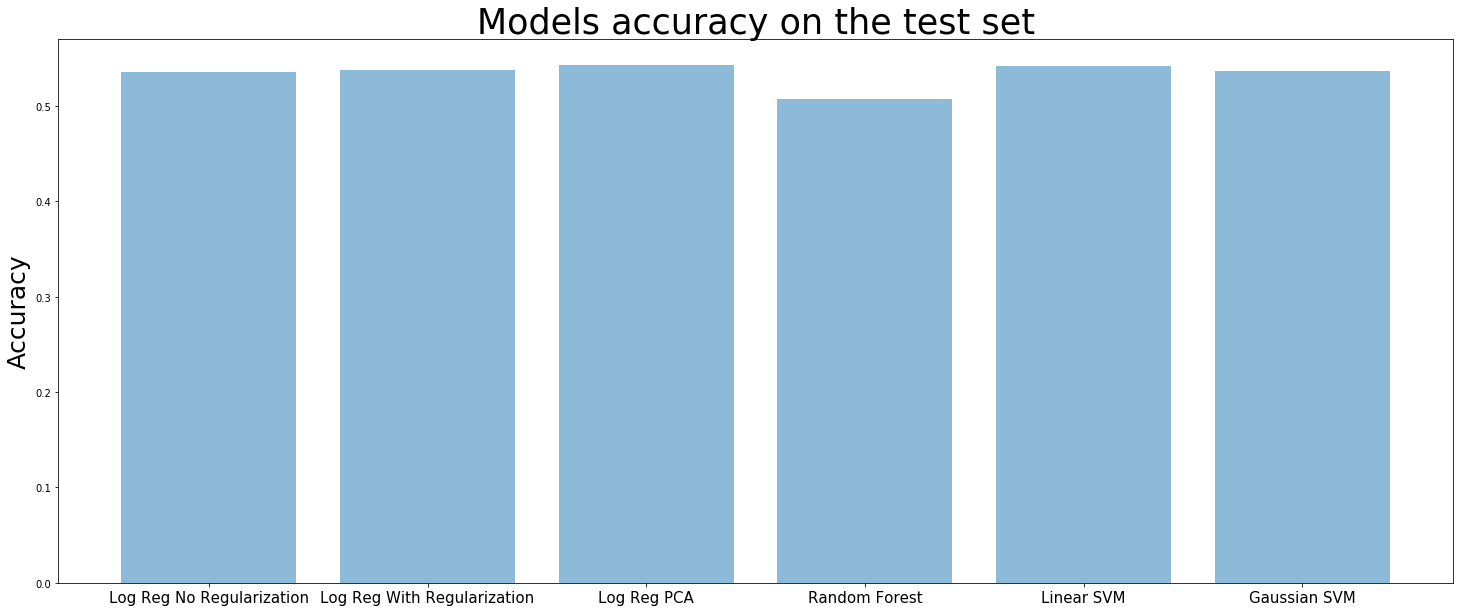

In [34]:
# Compare accuracy per model visually using matplotlib

objects = ('Log Reg No Regularization', 'Log Reg With Regularization', 'Log Reg PCA', 
           'Random Forest', 'Linear SVM', 'Gaussian SVM')
y_pos = np.arange(len(objects))
performance = [model_log_reg_basic_accuracy, tuned_model_accuracy, gridModelLogRegPCA_accuracy,
               random_forest_score_accuracy_test, linear_svm_score_accuracy, gaussian_svm_score_accuracy]
 
plt.rcParams['figure.figsize'] = (25,10)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,fontsize=15)
plt.ylabel('Accuracy', fontsize = 25)
plt.title('Models accuracy on the test set', fontsize = 35)



### Conclusions and model choice

All the machine learning models used for forecasting Goal/Goal match outcome for the English Premier League give similar results on the data collected. 

The models give better than random performance, but still cannot come close to the intrinsic error we should expect from such data - namely an error allowing for around 60% accuracy. 

This means that the data collected is not good enough for predictive purposes and that there are factors affecting the target column not included in the initial dataset. Even more extensive data gathering process shall be perfomed in order to make these results better and to improve the accuracy of the model. 

As it comes to the data and the models presented in the project - __the best choice is the Logistic Regression with regularization parameter C = 0.1__ for forecasting. This is the simplest model as it comes to data preprocessing (compared to Log Reg with PCA for ex.) and still gives competitive results compared to more sophisticated models.  